# Mushroom Classifier

This notebook implements a multilayer neural network model that can classify mushrooms as edible or poisonous based on their physical characteristics. There are over 8000 samples with 22 features (and a label) each.

The model is trained on:
> https://www.kaggle.com/datasets/uciml/mushroom-classification

### Imports
Some libraries will be needed to run this notebook. The libraries are:
> pandas, to read the CSV files and manipulate the data.

> torch, to create the model, train it and evaluate it.

> sklearn, to split the dataset into training and test sets, scale and classify the model.

> matplotlib, to plot the data and some model metrics.

In [104]:
import pandas as pd

import torch
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

### Data Exploration

It is important to understand the data before building a model. The first step is to read the CSV file and create a pandas dataframe with the data.

In [105]:
df = pd.read_csv('mushrooms.csv')
df.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [106]:
df.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [107]:
df.dtypes

class                       object
cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
dtype: object

Splittig the data into features and labels.

In [108]:
X = df.drop('class', axis=1)
y = df['class']

y.sample(5)

4325    p
3593    e
5191    p
2250    e
3776    e
Name: class, dtype: object

It is necessary to turn the categorical data into numerical data. This is done by using the pandas get_dummies() function.

In [109]:
X = pd.get_dummies(X, dtype='int64')
y = pd.get_dummies(y, dtype='int64')

X.shape, y.shape

((8124, 117), (8124, 2))

In [110]:
y.sample(5)

,e,p
6533,0,1
6814,0,1
4089,1,0
670,1,0
1048,1,0


In [111]:
X.sample(5)

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
4314,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
3889,0,0,0,0,0,1,1,0,0,0,...,0,1,0,1,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
653,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
3054,0,0,1,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0


Splittig the data into training and test sets.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5686, 117), (2438, 117), (5686, 2), (2438, 2))

As Pytorch works with tensors, we need to convert our data into tensors.

In [113]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_train = torch.from_numpy(y_train.to_numpy()).float()
y_test = torch.from_numpy(y_test.to_numpy()).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5686, 117]),
 torch.Size([2438, 117]),
 torch.Size([5686, 2]),
 torch.Size([2438, 2]))

### Model

In [114]:
class MushroomClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(input_size, 128), nn.ReLU(),
                                 nn.Linear(128, 64), nn.ReLU(),
                                 nn.Linear(64, 32), nn.ReLU(),
                                 nn.Linear(32, 16), nn.ReLU(),
                                 nn.Linear(16, output_size))
        
    def forward(self, x):
        return self.net(x)
    
    def predict(self, x):
        return self.net(x).argmax(dim=1)
        

In [115]:
torch.manual_seed(9)

n_features = X_train.shape[1]
n_classes = y_train.shape[1]
model_0 = MushroomClassifier(n_features, n_classes)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [116]:
def train(model, max_epochs, loss_fn, optimizer):
    train_loss_list = []
    test_loss_list = []
    
    for epoch in range(1, max_epochs+1):
        model.train()
        y_pred = model(X_train)
        
        loss = loss_fn(y_pred, y_train)
        train_loss_list.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.inference_mode():
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_loss_list.append(test_loss.item())

        if epoch % 100 == 0:
            print(f"Epoch: {epoch} | Train loss: {loss.item()} | Test loss: {test_loss.item()}")
            
    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(train_loss_list[500:], label='Train loss')
    ax.plot(test_loss_list[500:], label='Test loss')
    ax.set_title("Loss value during training")
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss (CrossEntropy)')
    ax.legend()

Epoch: 100 | Train loss: 0.0004460011550690979 | Test loss: 0.0005789659917354584
Epoch: 200 | Train loss: 0.00011298029858153313 | Test loss: 0.0001567410072311759
Epoch: 300 | Train loss: 5.6579890951979905e-05 | Test loss: 7.954108150443062e-05
Epoch: 400 | Train loss: 3.413845115574077e-05 | Test loss: 4.8428359150420874e-05
Epoch: 500 | Train loss: 2.2819380319560878e-05 | Test loss: 3.258067954448052e-05
Epoch: 600 | Train loss: 1.630000951990951e-05 | Test loss: 2.3405940737575293e-05
Epoch: 700 | Train loss: 1.2203530786791816e-05 | Test loss: 1.7628573914407752e-05
Epoch: 800 | Train loss: 9.456336556468159e-06 | Test loss: 1.3734606000070926e-05
Epoch: 900 | Train loss: 7.527570687670959e-06 | Test loss: 1.0989334441546816e-05
Epoch: 1000 | Train loss: 6.119430508988444e-06 | Test loss: 8.984819942270406e-06
Epoch: 1100 | Train loss: 5.062952368461993e-06 | Test loss: 7.472738161595771e-06
Epoch: 1200 | Train loss: 4.248478944646195e-06 | Test loss: 6.299981123447651e-06
Epoc

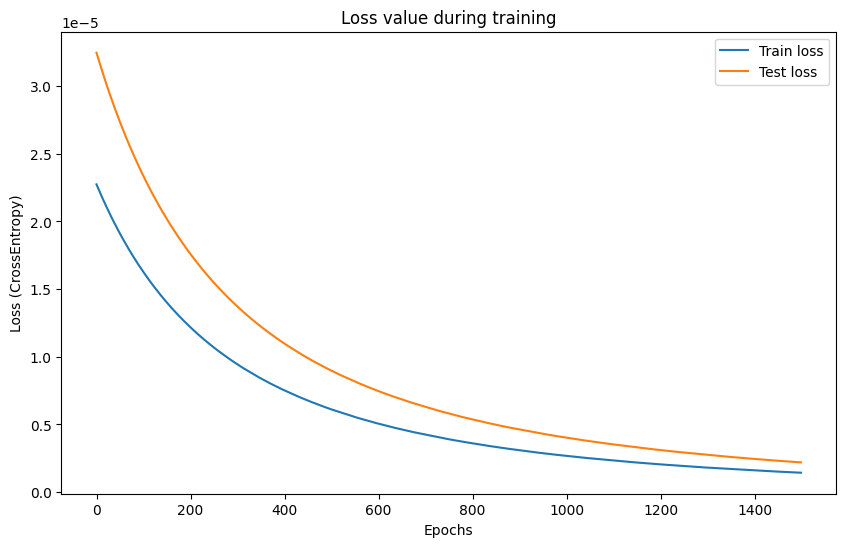

In [117]:
train(model_0, 2000, loss_fn, optimizer)

In [118]:
y_categorical = []
for cl in y_test:
    y_categorical.append(torch.argmax(cl).item())

The model has a great performance, with an accuracy of 100% on validation test set. Most of it is due to the large amount of data available.

In [119]:
model_0.eval()
with torch.inference_mode():
    y_pred = model_0.predict(X_test).detach().numpy()
    print(classification_report(y_categorical, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1291
           1       1.00      1.00      1.00      1147

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438

